In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-10 18:46:16.297628: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 18:46:18.577959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 18:46:20.946805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def datacleaning_imdb():
    dataset = load_dataset("sst2")
    train_data = dataset['train']

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame

    df['sentiment'] = df['label'].map({0: 'bad', 1: 'good'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Print the class name, accuracy numerator and denominator.
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]

            # L1 regularization
            l1_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            
            # L2 regularization
            l2_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2)

            
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_bert_gpt_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_imdb()

Found cached dataset sst2 (/home/z123010/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,idx,sentence,label,sentiment,data_type
66730,66730,with outtakes in which most of the characters ...,0,bad,train
29890,29890,enigma is well-made,1,good,train
45801,45801,is ) so stoked to make an important film about...,0,bad,train
29352,29352,the closest thing to the experience of space t...,1,good,train
19858,19858,lose their luster,0,bad,train
15364,15364,reopens an interesting controversy and,1,good,train
30026,30026,"competent , unpretentious entertainment",1,good,train
38039,38039,an effective portrait of a life in stasis,1,good,train
14261,14261,transcendent performance,1,good,train
11661,11661,so vivid,1,good,train


In [6]:
df.groupby(['sentiment']).count()

,idx,sentence,label,data_type
sentiment,,,,
bad,29780,29780,29780,29780
good,37569,37569,37569,37569


In [7]:
# Load BERT tokenizer
pretrained_path = 'bert-base-uncased'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_text = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].sentence.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train_text['input_ids']
attention_masks_train = encoded_data_train_text['attention_mask']

labels_train = torch.tensor(df[df.data_type=='train'].label.values)

encoded_data_val_text = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].sentence.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val = encoded_data_val_text['input_ids']
attention_masks_val = encoded_data_val_text['attention_mask']

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [8]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(57246, 10103)

In [9]:
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 2

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config.from_pretrained(
            pretrained_gpt_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.1)
        self.gpt = GPT2Model.from_pretrained(pretrained_gpt_path, config=gpt_config)
        
        bert_config = BertConfig.from_pretrained(pretrained_bert_path)
        self.bert = BertModel.from_pretrained(pretrained_bert_path, config=bert_config)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        
        combined_outputs = torch.cat((gpt_last_hidden_state, bert_pooled_output), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [10]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Define the regularization strength
lambda_l1 = 0.001
lambda_l2 = 0.001
# Define the loss function
criterion = nn.CrossEntropyLoss()

In [12]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddin

In [13]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 25
patience = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.2911232434162247
Validation loss: 0.2201896571606598
F1 Score (weighted): 0.9463308784127752


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.17023169246298145
Validation loss: 0.20105829936955918
F1 Score (weighted): 0.9514152962081902
41.53% Training loss decreased compared to the previous epoch
8.69% Validation loss decreased compared to the previous epoch
0.54% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.11753806577447466
Validation loss: 0.2633244227279586
F1 Score (weighted): 0.9484431093505377
30.95% Training loss decreased compared to the previous epoch
30.97% Validation loss increased compared to the previous epoch
0.31% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.08409473377878547
Validation loss: 0.3198774276184423
F1 Score (weighted): 0.9499789834743766
28.45% Training loss decreased compared to the previous epoch
21.48% Validation loss increased compared to the previous epoch
0.16% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.06270483159223977
Validation loss: 0.324973735028509
F1 Score (weighted): 0.9457392175621978
25.44% Training loss decreased compared to the previous epoch
1.59% Validation loss increased compared to the previous epoch
0.45% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.04729338933347368
Validation loss: 0.3748401251790832
F1 Score (weighted): 0.9475558444196204
24.58% Training loss decreased compared to the previous epoch
15.34% Validation loss increased compared to the previous epoch
0.19% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.039367151627350494
Validation loss: 0.35559332125030374
F1 Score (weighted): 0.9470820557917798
16.76% Training loss decreased compared to the previous epoch
5.13% Validation loss decreased compared to the previous epoch
0.05% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 140.17828956047694 minutes
Final Accuracy: 0.9470742358078602
Final Precision: 0.9470927428769078


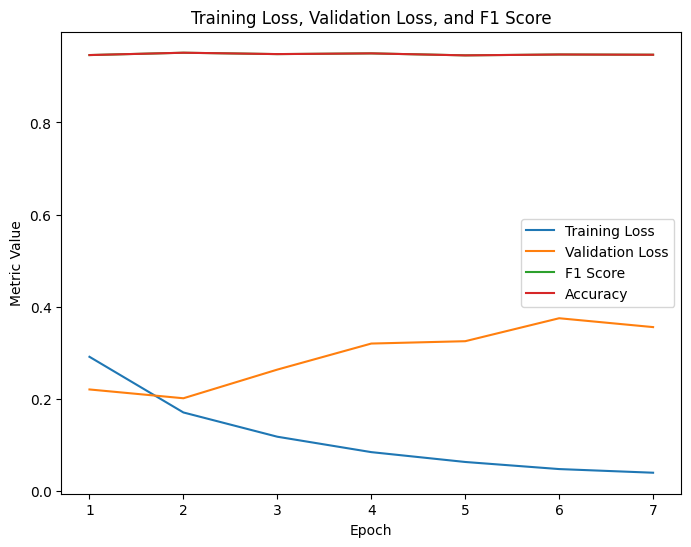

Epoch                 Training Loss         Validation Loss      F1 Score            Accuracy              Precision
--------------------  --------------------  -------------------  ------------------  ------------------  -----------
1                     0.2911232434162247    0.2201896571606598   0.9463308784127752  0.9463755458515284     0.946367
2                     0.17023169246298145   0.20105829936955918  0.9514152962081902  0.9514152962081902     0.951415
3                     0.11753806577447466   0.2633244227279586   0.9484431093505377  0.9484431093505377     0.948443
4                     0.08409473377878547   0.3198774276184423   0.9499789834743766  0.9499789834743766     0.949979
5                     0.06270483159223977   0.324973735028509    0.9457392175621978  0.9457392175621978     0.945739
6                     0.04729338933347368   0.3748401251790832   0.9475558444196204  0.9475558444196204     0.947556
7                     0.039367151627350494  0.35559332125030374 

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.06079270365274461
Validation loss: 0.015534142532426777
F1 Score (weighted): 0.9956334592910762


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.036907338753145016
Validation loss: 0.02705232424961762
F1 Score (weighted): 0.9942356876590445
39.29% Training loss decreased compared to the previous epoch
74.15% Validation loss increased compared to the previous epoch
0.14% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.025800070877492493
Validation loss: 0.04043604602478473
F1 Score (weighted): 0.9928391678205903
30.1% Training loss decreased compared to the previous epoch
49.47% Validation loss increased compared to the previous epoch
0.14% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.018285424166034795
Validation loss: 0.0433217800999188
F1 Score (weighted): 0.9924895499806508
29.13% Training loss decreased compared to the previous epoch
7.14% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.015085766006601092
Validation loss: 0.05077398906759396
F1 Score (weighted): 0.9926643627262562
17.5% Training loss decreased compared to the previous epoch
17.2% Validation loss increased compared to the previous epoch
0.02% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.013505485170435823
Validation loss: 0.07279888318009535
F1 Score (weighted): 0.9910903907924109
10.48% Training loss decreased compared to the previous epoch
43.38% Validation loss increased compared to the previous epoch
0.16% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 120.04790380795797 minutes
Final Accuracy: 0.9910917030567685
Final Precision: 0.9910920844377491


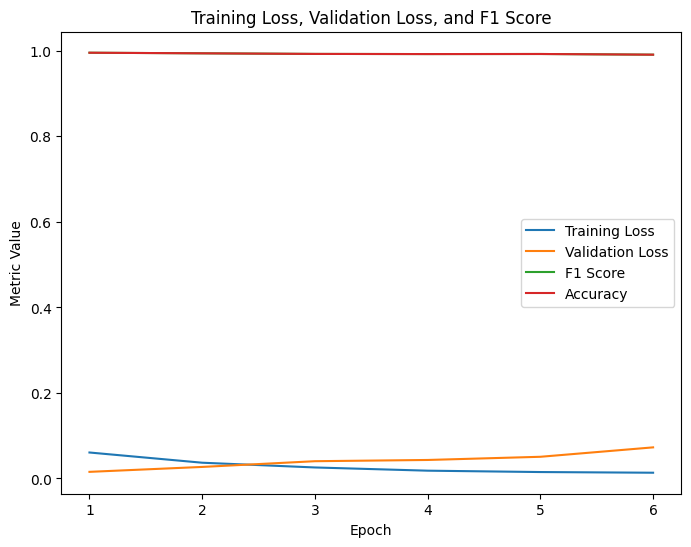

Epoch                 Training Loss         Validation Loss       F1 Score            Accuracy              Precision
--------------------  --------------------  --------------------  ------------------  ------------------  -----------
1                     0.06079270365274461   0.015534142532426777  0.9956334592910762  0.9956331877729258     0.995634
2                     0.036907338753145016  0.02705232424961762   0.9942356876590445  0.9942356876590445     0.994236
3                     0.025800070877492493  0.04043604602478473   0.9928391678205903  0.9928391678205903     0.992839
4                     0.018285424166034795  0.0433217800999188    0.9924895499806508  0.9924895499806508     0.99249
5                     0.015085766006601092  0.05077398906759396   0.9926643627262562  0.9926643627262562     0.992664
6                     0.013505485170435823  0.07279888318009535   0.9910903907924109  0.9910903907924109     0.99109
Total Training Time                                       

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.015364977024763988
Validation loss: 0.0045870494750069254
F1 Score (weighted): 0.9991266553782947


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.009271880722965186
Validation loss: 0.007521709432451227
F1 Score (weighted): 0.9984279154157246
39.66% Training loss decreased compared to the previous epoch
63.98% Validation loss increased compared to the previous epoch
0.07% F1 Score decreased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.007403825047244645
Validation loss: 0.014207505958070825
F1 Score (weighted): 0.9973799661348842
20.15% Training loss decreased compared to the previous epoch
88.89% Validation loss increased compared to the previous epoch
0.1% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.006477377583327816
Validation loss: 0.009616382718545907
F1 Score (weighted): 0.9984278507510402
12.51% Training loss decreased compared to the previous epoch
32.31% Validation loss decreased compared to the previous epoch
0.11% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.005978263893512117
Validation loss: 0.01206392210676882
F1 Score (weighted): 0.9979040155516996
7.71% Training loss decreased compared to the previous epoch
25.45% Validation loss increased compared to the previous epoch
0.05% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.004776619712205644
Validation loss: 0.0119109461728819
F1 Score (weighted): 0.9979041004400478
20.1% Training loss decreased compared to the previous epoch
1.27% Validation loss decreased compared to the previous epoch
0.0% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 119.96113007068634 minutes
Final Accuracy: 0.9979039301310043
Final Precision: 0.9979052578252828


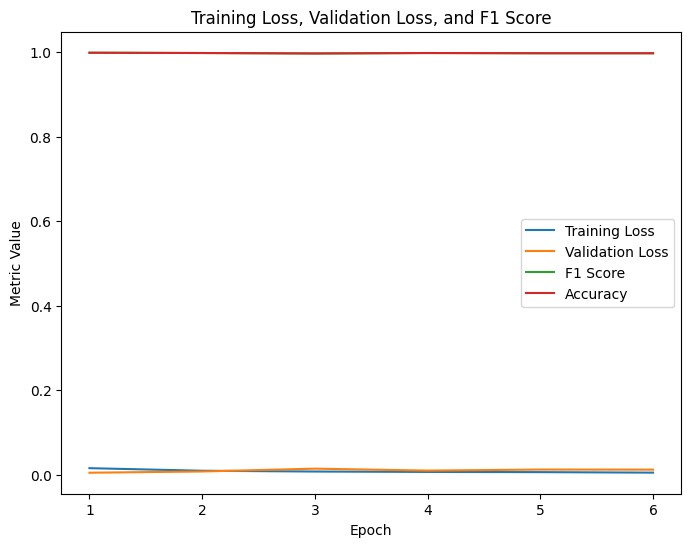

Epoch                 Training Loss         Validation Loss        F1 Score            Accuracy              Precision
--------------------  --------------------  ---------------------  ------------------  ------------------  -----------
1                     0.015364977024763988  0.0045870494750069254  0.9991266553782947  0.9991266375545852     0.999127
2                     0.009271880722965186  0.007521709432451227   0.9984279154157246  0.9984279154157246     0.998428
3                     0.007403825047244645  0.014207505958070825   0.9973799661348842  0.9973799661348842     0.99738
4                     0.006477377583327816  0.009616382718545907   0.9984278507510402  0.9984278507510402     0.998428
5                     0.005978263893512117  0.01206392210676882    0.9979040155516996  0.9979040155516996     0.997904
6                     0.004776619712205644  0.0119109461728819     0.9979041004400478  0.9979041004400478     0.997904
Total Training Time                              

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.004539790123034987
Validation loss: 0.0009035822551920177
F1 Score (weighted): 0.9998253242778005


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.004134895060866511
Validation loss: 0.0015221451307841983
F1 Score (weighted): 0.9998253242778005
8.92% Training loss decreased compared to the previous epoch
68.46% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.002655165478878692
Validation loss: 2.708129231073322e-06
F1 Score (weighted): 1.0
35.79% Training loss decreased compared to the previous epoch
99.82% Validation loss decreased compared to the previous epoch
0.02% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0022212625233667288
Validation loss: 8.508716540512084e-05
F1 Score (weighted): 1.0
16.34% Training loss decreased compared to the previous epoch
3041.92% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.001589747294304425
Validation loss: 0.0007145773888692083
F1 Score (weighted): 0.9998253242778005
28.43% Training loss decreased compared to the previous epoch
739.82% Validation loss increased compared to the previous epoch
0.02% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0007089903145817698
Validation loss: 1.3673858281141272e-06
F1 Score (weighted): 1.0
55.4% Training loss decreased compared to the previous epoch
99.81% Validation loss decreased compared to the previous epoch
0.02% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0010691189232454078
Validation loss: 1.532963981551868e-06
F1 Score (weighted): 1.0
50.79% Training loss increased compared to the previous epoch
12.11% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0006569758435845147
Validation loss: 1.3091088946030698e-06
F1 Score (weighted): 1.0
38.55% Training loss decreased compared to the previous epoch
14.6% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0007613102187715103
Validation loss: 1.2949951936266772e-06
F1 Score (weighted): 1.0
15.88% Training loss increased compared to the previous epoch
1.08% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0011055928256443403
Validation loss: 1.295020166226705e-06
F1 Score (weighted): 1.0
45.22% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.000491604595601888
Validation loss: 1.2948952954463225e-06
F1 Score (weighted): 1.0
55.53% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0005366818870791975
Validation loss: 1.2950076825862645e-06
F1 Score (weighted): 1.0
9.17% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.00057991691606898
Validation loss: 1.2949827062548951e-06
F1 Score (weighted): 1.0
8.06% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.0009400623416524596
Validation loss: 1.2950451409702692e-06
F1 Score (weighted): 1.0
62.1% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 15:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0011594597180623588
Validation loss: 1.294982703396846e-06
F1 Score (weighted): 1.0
23.34% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 16:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.00027348457783104885
Validation loss: 1.2950451433519768e-06
F1 Score (weighted): 1.0
76.41% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 319.64317266146344 minutes
Final Accuracy: 1.0
Final Precision: 1.0


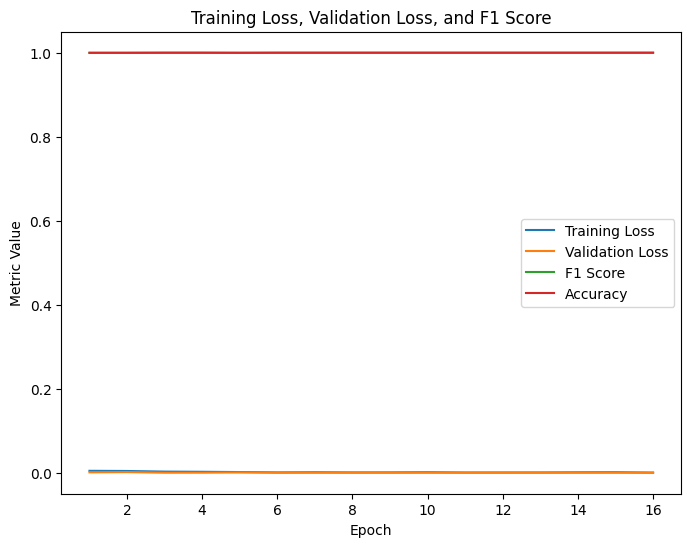

Epoch                 Training Loss           Validation Loss         F1 Score            Accuracy               Precision
--------------------  ----------------------  ----------------------  ------------------  ------------------  ------------
1                     0.004539790123034987    0.0009035822551920177   0.9998253242778005  0.999825327510917       0.999825
2                     0.004134895060866511    0.0015221451307841983   0.9998253242778005  0.9998253242778005      0.999825
3                     0.002655165478878692    2.708129231073322e-06   1.0                 1.0                     1
4                     0.0022212625233667288   8.508716540512084e-05   1.0                 1.0                     1
5                     0.001589747294304425    0.0007145773888692083   0.9998253242778005  0.9998253242778005      0.999825
6                     0.0007089903145817698   1.3673858281141272e-06  1.0                 1.0                     1
7                     0.0010691189232

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0013295976431326431
Validation loss: 1.0850534992264506e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0009328206290774617
Validation loss: 1.085115935926581e-06
F1 Score (weighted): 1.0
29.84% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0008866702953281423
Validation loss: 1.0850160397309825e-06
F1 Score (weighted): 1.0
4.95% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0012187588748598045
Validation loss: 1.085028525356179e-06
F1 Score (weighted): 1.0
37.45% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0010100748372343753
Validation loss: 1.0850534998615727e-06
F1 Score (weighted): 1.0
17.12% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0003927037216714601
Validation loss: 1.085103449904433e-06
F1 Score (weighted): 1.0
61.12% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0016425402536037444
Validation loss: 1.085115936244142e-06
F1 Score (weighted): 1.0
318.26% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0005263454575106102
Validation loss: 1.0850784754784298e-06
F1 Score (weighted): 1.0
67.96% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 159.9203269481659 minutes
Final Accuracy: 1.0
Final Precision: 1.0


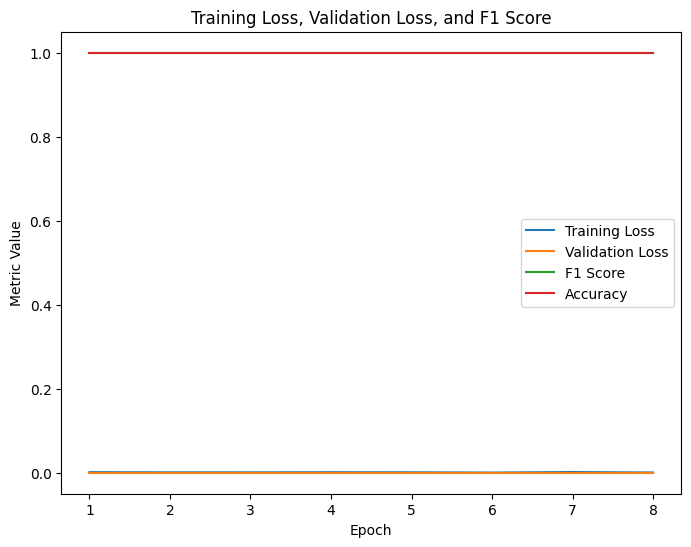

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.0013295976431326431  1.0850534992264506e-06  1.0         1.0                1
2                     0.0009328206290774617  1.085115935926581e-06   1.0         1.0                1
3                     0.0008866702953281423  1.0850160397309825e-06  1.0         1.0                1
4                     0.0012187588748598045  1.085028525356179e-06   1.0         1.0                1
5                     0.0010100748372343753  1.0850534998615727e-06  1.0         1.0                1
6                     0.0003927037216714601  1.085103449904433e-06   1.0         1.0                1
7                     0.0016425402536037444  1.085115936244142e-06   1.0         1.0                1
8                     0.0005263454575106102  1.0850784754784298e-06  1.0    

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.001045230375014885
Validation loss: 0.00014186352425046644
F1 Score (weighted): 0.9998253234104315


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0010700886094755539
Validation loss: 0.00014186358668311766
F1 Score (weighted): 0.9998253234104315
2.38% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.00078434335259922
Validation loss: 0.00014186363663316052
F1 Score (weighted): 0.9998253234104315
26.7% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0010716128384028823
Validation loss: 0.00014186353673918784
F1 Score (weighted): 0.9998253234104315
36.63% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0010982645802664094
Validation loss: 0.0001418635117627771
F1 Score (weighted): 0.9998253234104315
2.49% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.001266317422877471
Validation loss: 0.00014186348678914498
F1 Score (weighted): 0.9998253234104315
15.3% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0008735137773331355
Validation loss: 0.00014186352425102217
F1 Score (weighted): 0.9998253234104315
31.02% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0010676541962685688
Validation loss: 0.00014186356171099396
F1 Score (weighted): 0.9998253234104315
22.23% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.001299921772653505
Validation loss: 0.00014186376150433785
F1 Score (weighted): 0.9998253234104315
21.75% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0009660954323656561
Validation loss: 0.00014186342435387387
F1 Score (weighted): 0.9998253234104315
25.68% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0005776159345008985
Validation loss: 0.0001418635741972543
F1 Score (weighted): 0.9998253234104315
40.21% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.000601781425381588
Validation loss: 0.00014186347430328162
F1 Score (weighted): 0.9998253234104315
4.18% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.00027443820123507906
Validation loss: 0.00014186353674244283
F1 Score (weighted): 0.9998253234104315
54.4% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 14:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.0005590987254092248
Validation loss: 0.0001418636116613544
F1 Score (weighted): 0.9998253234104315
103.72% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 15:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.0009838763604070844
Validation loss: 0.00014186349927556408
F1 Score (weighted): 0.9998253234104315
75.98% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 300.07968322436017 minutes
Final Accuracy: 0.999825327510917
Final Precision: 0.999825381405545


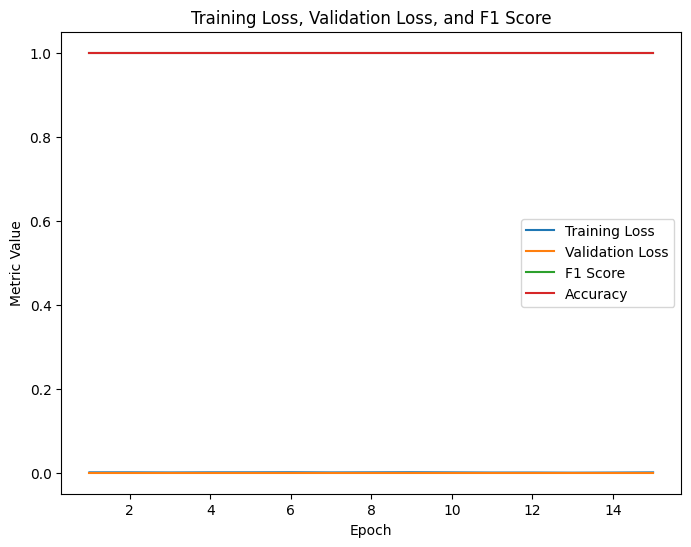

Epoch                 Training Loss           Validation Loss         F1 Score            Accuracy               Precision
--------------------  ----------------------  ----------------------  ------------------  ------------------  ------------
1                     0.001045230375014885    0.00014186352425046644  0.9998253234104315  0.999825327510917       0.999825
2                     0.0010700886094755539   0.00014186358668311766  0.9998253234104315  0.9998253234104315      0.999825
3                     0.00078434335259922     0.00014186363663316052  0.9998253234104315  0.9998253234104315      0.999825
4                     0.0010716128384028823   0.00014186353673918784  0.9998253234104315  0.9998253234104315      0.999825
5                     0.0010982645802664094   0.0001418635117627771   0.9998253234104315  0.9998253234104315      0.999825
6                     0.001266317422877471    0.00014186348678914498  0.9998253234104315  0.9998253234104315      0.999825
7               

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0007321085465004058
Validation loss: 1.077607195382284e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0011454438845872959
Validation loss: 1.0776488213574522e-06
F1 Score (weighted): 1.0
56.46% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0011245885807166446
Validation loss: 1.0776904432837177e-06
F1 Score (weighted): 1.0
1.82% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.001514805520310718
Validation loss: 1.0775655745674817e-06
F1 Score (weighted): 1.0
34.7% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.000782690057350371
Validation loss: 1.0775447620959343e-06
F1 Score (weighted): 1.0
48.33% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0006497705633195476
Validation loss: 1.0776280109500512e-06
F1 Score (weighted): 1.0
16.98% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0010360443961181767
Validation loss: 1.0777320706879105e-06
F1 Score (weighted): 1.0
59.45% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0007607218917982764
Validation loss: 1.0778153138259296e-06
F1 Score (weighted): 1.0
26.57% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0006555556510323988
Validation loss: 1.0776696319236337e-06
F1 Score (weighted): 1.0
13.82% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0010852054414946662
Validation loss: 1.0777112533735578e-06
F1 Score (weighted): 1.0
65.54% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 200.046076242129 minutes
Final Accuracy: 1.0
Final Precision: 1.0


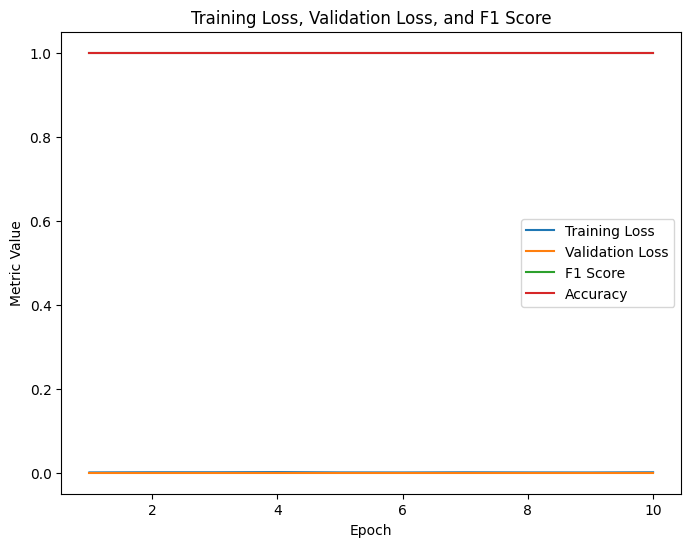

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.0007321085465004058  1.077607195382284e-06   1.0         1.0               1
2                     0.0011454438845872959  1.0776488213574522e-06  1.0         1.0               1
3                     0.0011245885807166446  1.0776904432837177e-06  1.0         1.0               1
4                     0.001514805520310718   1.0775655745674817e-06  1.0         1.0               1
5                     0.000782690057350371   1.0775447620959343e-06  1.0         1.0               1
6                     0.0006497705633195476  1.0776280109500512e-06  1.0         1.0               1
7                     0.0010360443961181767  1.0777320706879105e-06  1.0         1.0               1
8                     0.0007607218917982764  1.0778153138259296e-06  1.0         1.

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0008272623707496977
Validation loss: 0.00022724329028207138
F1 Score (weighted): 0.9998253002905921


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.001548726904143921
Validation loss: 0.00022724331109287574
F1 Score (weighted): 0.9998253002905921
87.21% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0005912048563497766
Validation loss: 0.00022724339433958631
F1 Score (weighted): 0.9998253002905921
61.83% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0011208787084926002
Validation loss: 0.00022724337352751173
F1 Score (weighted): 0.9998253002905921
89.59% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0009423226120387734
Validation loss: 0.00022724329027587893
F1 Score (weighted): 0.9998253002905921
15.93% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.000839007155323012
Validation loss: 0.0002272434775844709
F1 Score (weighted): 0.9998253002905921
10.96% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.000597328036288604
Validation loss: 0.00022724329028429432
F1 Score (weighted): 0.9998253002905921
28.81% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.00040227490158245213
Validation loss: 0.00022724320703432872
F1 Score (weighted): 0.9998253002905921
32.65% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0009918949376892343
Validation loss: 0.00022724347758836105
F1 Score (weighted): 0.9998253002905921
146.57% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.00040009534845184295
Validation loss: 0.00022724339434006266
F1 Score (weighted): 0.9998253002905921
59.66% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0012311993799408924
Validation loss: 0.00022724333190653813
F1 Score (weighted): 0.9998253002905921
207.73% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.00045200956244328825
Validation loss: 0.00022724329027937212
F1 Score (weighted): 0.9998253002905921
63.29% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.0016533149612211013
Validation loss: 0.00022724339433744276
F1 Score (weighted): 0.9998253002905921
265.77% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 260.5714585185051 minutes
Final Accuracy: 0.9998252969951084
Final Precision: 0.999825365318536


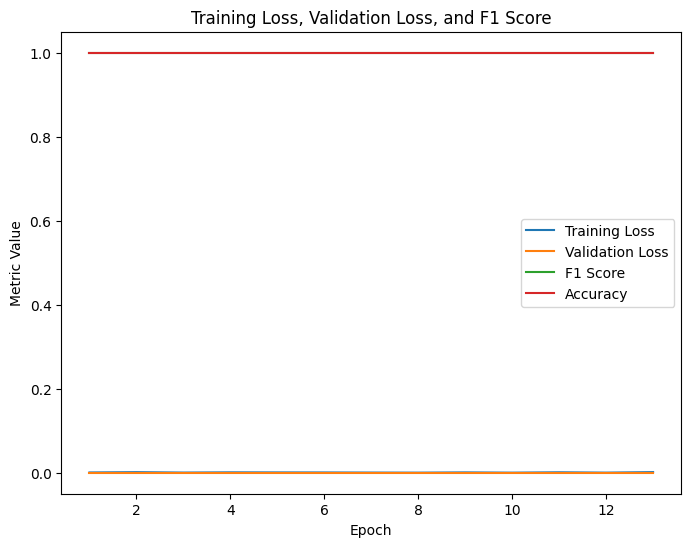

Epoch                 Training Loss           Validation Loss         F1 Score            Accuracy               Precision
--------------------  ----------------------  ----------------------  ------------------  ------------------  ------------
1                     0.0008272623707496977   0.00022724329028207138  0.9998253002905921  0.9998252969951084      0.999825
2                     0.001548726904143921    0.00022724331109287574  0.9998253002905921  0.9998253002905921      0.999825
3                     0.0005912048563497766   0.00022724339433958631  0.9998253002905921  0.9998253002905921      0.999825
4                     0.0011208787084926002   0.00022724337352751173  0.9998253002905921  0.9998253002905921      0.999825
5                     0.0009423226120387734   0.00022724329027587893  0.9998253002905921  0.9998253002905921      0.999825
6                     0.000839007155323012    0.0002272434775844709   0.9998253002905921  0.9998253002905921      0.999825
7               

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0017038628892146613
Validation loss: 1.0719672378062107e-06
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0018894129193308617
Validation loss: 1.0720088613996716e-06
F1 Score (weighted): 1.0
10.89% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.001129337786240401
Validation loss: 1.0721129184382624e-06
F1 Score (weighted): 1.0
40.23% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.0008487453222954842
Validation loss: 1.0721129220902138e-06
F1 Score (weighted): 1.0
24.85% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0006118794740197912
Validation loss: 1.0721961706267698e-06
F1 Score (weighted): 1.0
27.91% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.001254257296083091
Validation loss: 1.0720504883275227e-06
F1 Score (weighted): 1.0
104.98% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 120.02109599113464 minutes
Final Accuracy: 1.0
Final Precision: 1.0


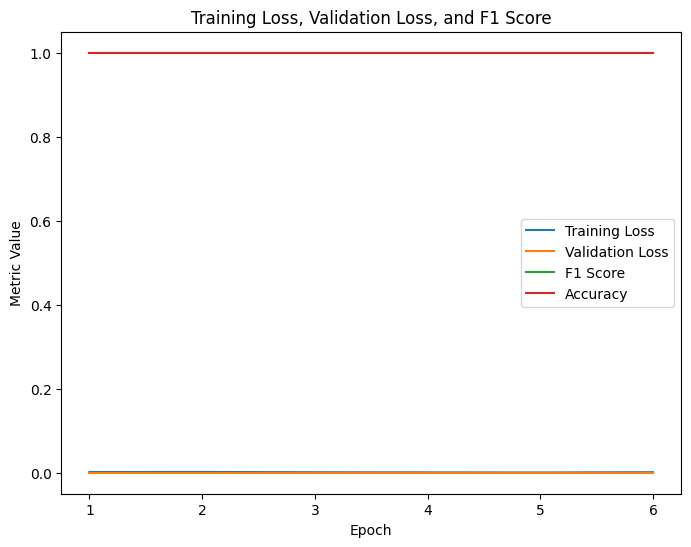

Epoch                 Training Loss          Validation Loss         F1 Score    Accuracy      Precision
--------------------  ---------------------  ----------------------  ----------  ----------  -----------
1                     0.0017038628892146613  1.0719672378062107e-06  1.0         1.0               1
2                     0.0018894129193308617  1.0720088613996716e-06  1.0         1.0               1
3                     0.001129337786240401   1.0721129184382624e-06  1.0         1.0               1
4                     0.0008487453222954842  1.0721129220902138e-06  1.0         1.0               1
5                     0.0006118794740197912  1.0721961706267698e-06  1.0         1.0               1
6                     0.001254257296083091   1.0720504883275227e-06  1.0         1.0               1
Total Training Time                                                                             7201.27
Final Precision                                                                 

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.0011589614878340989
Validation loss: 5.6920900253193875e-05
F1 Score (weighted): 1.0


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.001165879817690228
Validation loss: 5.6920983496728844e-05
F1 Score (weighted): 1.0
0.6% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.0012942963176324608
Validation loss: 5.692079619440869e-05
F1 Score (weighted): 1.0
11.01% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.00023485413347261848
Validation loss: 5.69208794392933e-05
F1 Score (weighted): 1.0
81.85% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.000624949893510888
Validation loss: 5.692087944143684e-05
F1 Score (weighted): 1.0
166.1% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0006274169419736761
Validation loss: 5.692079619337662e-05
F1 Score (weighted): 1.0
0.39% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0009934384368182998
Validation loss: 5.692079619623467e-05
F1 Score (weighted): 1.0
58.34% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.001352535559361236
Validation loss: 5.692079619155065e-05
F1 Score (weighted): 1.0
36.15% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.0008514843046357687
Validation loss: 5.6920879438340616e-05
F1 Score (weighted): 1.0
37.05% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.00024542953088169876
Validation loss: 5.692096268354278e-05
F1 Score (weighted): 1.0
71.18% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0009375946604975324
Validation loss: 5.6920817001005366e-05
F1 Score (weighted): 1.0
282.02% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0009589076348589756
Validation loss: 5.6920858626980534e-05
F1 Score (weighted): 1.0
2.27% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.0011849606591912648
Validation loss: 5.6920941871468186e-05
F1 Score (weighted): 1.0
23.57% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 260.0162259221077 minutes
Final Accuracy: 1.0
Final Precision: 1.0


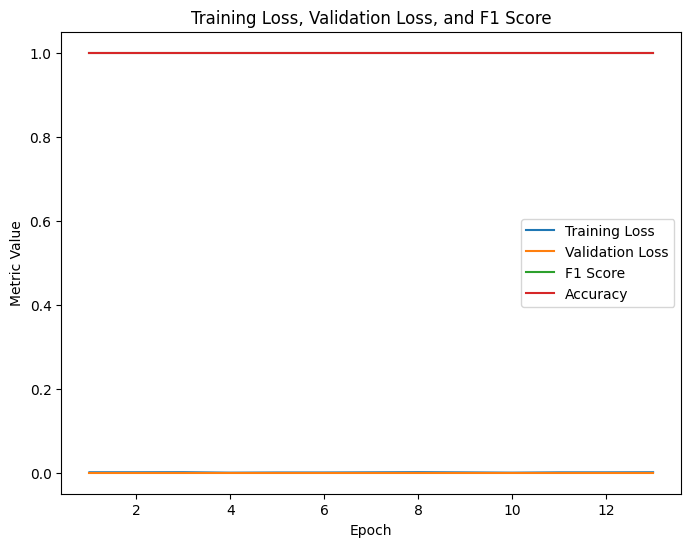

Epoch                 Training Loss           Validation Loss         F1 Score    Accuracy      Precision
--------------------  ----------------------  ----------------------  ----------  ----------  -----------
1                     0.0011589614878340989   5.6920900253193875e-05  1.0         1.0               1
2                     0.001165879817690228    5.6920983496728844e-05  1.0         1.0               1
3                     0.0012942963176324608   5.692079619440869e-05   1.0         1.0               1
4                     0.00023485413347261848  5.69208794392933e-05    1.0         1.0               1
5                     0.000624949893510888    5.692087944143684e-05   1.0         1.0               1
6                     0.0006274169419736761   5.692079619337662e-05   1.0         1.0               1
7                     0.0009934384368182998   5.692079619623467e-05   1.0         1.0               1
8                     0.001352535559361236    5.692079619155065e-05   1.0 

In [19]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_val = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # train_model(trainer, dataloader_train, dataloader_val, epochs, patience)

    try:
        train_model(trainer, dataloader_train, dataloader_val, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

In [20]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_bert_gpt_ft_epoch10.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 2532/2532

Class: 1
Accuracy: 3192/3192



In [21]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_bert_gpt_ft_epoch10.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_train)
accuracy_per_class(predictions, true_vals)

Class: 0
Accuracy: 22780/22781

Class: 1
Accuracy: 28740/28741

